<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## 1. Reading Train and Test Data from Files

In [2]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [3]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'preferential_followees', 'preferential_followers',
       'num_followers_s', 'num_followers_d', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'svd_dot_source', 'svd_dot_destination'],
    

In [4]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,preferential_followees,preferential_followers,num_followers_s,...,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_source,svd_dot_destination
0,273084,1505602,1,0,0.000000,0.0,0.000000,120,66,11,...,8.108416e-13,1.719695e-14,-1.355226e-12,4.675304e-13,1.128578e-06,6.616688e-14,9.771000e-13,4.159935e-14,1.114947e-11,2.238754e-12
1,1796497,1321708,1,0,0.015385,0.0,0.035355,3200,4428,54,...,1.154566e-09,1.519086e-13,-2.534148e-11,6.451645e-09,2.373954e-09,7.657990e-12,6.106740e-10,1.102588e-13,1.678878e-17,1.056488e-17


In [5]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [6]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

## 2. Machine Learning Models

In [7]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Random ForestClassifier

###### Hyper ParameterTuning RandomForestClassifier

In [8]:
param_dist = { "n_estimators":[100,120,150],"max_depth": [5,10,15,20]}

estimator = RandomForestClassifier(random_state=25,n_jobs=-1,min_samples_leaf=50, min_samples_split=120)

grid_rf = GridSearchCV(estimator, param_grid=param_dist,cv=3,scoring='f1')
grid_rf.fit(df_final_train,y_train)
estimator = grid_rf.best_params_["n_estimators"]
depth = grid_rf.best_params_["max_depth"]
print("Number of Estimators:",estimator)
print("Optimal depth:",depth)

Number of Estimators: 150
Optimal depth: 15


###### With BestParameters

In [9]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.965222796237989
Test f1 score 0.9254397145042059


###### Confusion matrix

Train confusion_matrix


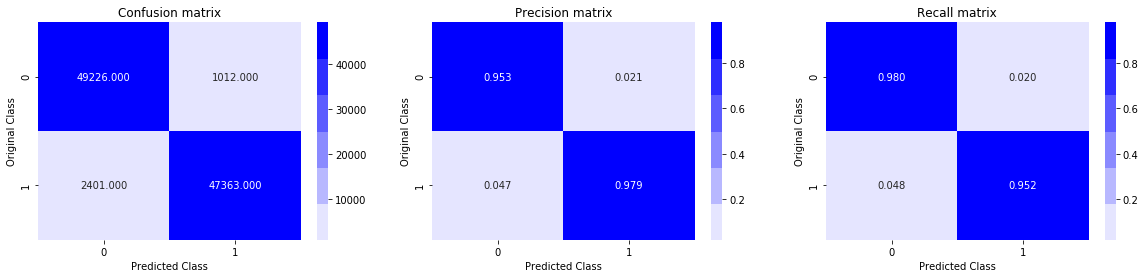

Test confusion_matrix


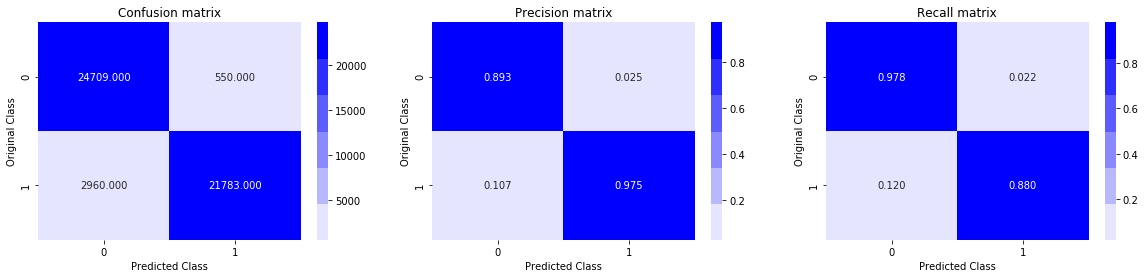

In [10]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

###### ROC Curve

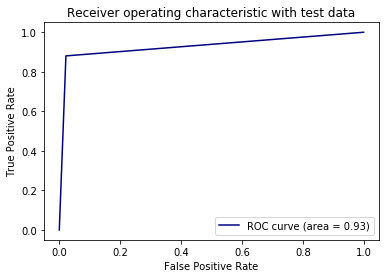

In [11]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

###### Feature Importance

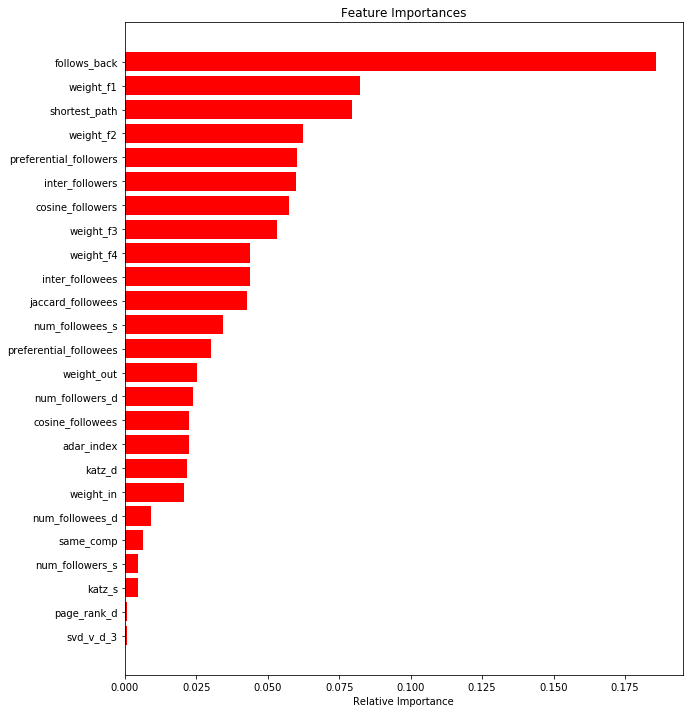

In [12]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### XGBoostClassifier

###### Hyper ParameterTuning XGBoostClassifier

In [13]:
warnings.filterwarnings("ignore")
estimator = xgb.XGBClassifier(n_jobs=-1)
param_grid = { "n_estimators":[80,100,120],"max_depth":[5,6,7,8]} 

grid_xgb = GridSearchCV(estimator,param_grid,scoring="f1",cv=3)
grid_xgb.fit(df_final_train,y_train)
estimator = grid_xgb.best_params_["n_estimators"]
depth = grid_xgb.best_params_["max_depth"]
print("Number of Estimators:",estimator)
print("Optimal depth:",depth)

Number of Estimators: 120
Optimal depth: 8


###### With Best Estimator

In [14]:
#For feature importance in xgboost we add parameter booster='gbtree'

clf = xgb.XGBClassifier(n_estimators=120, max_depth=8, booster='gbtree')
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9879067321887197
Test f1 score 0.9299205196137083


###### Confusion Matrix

Train confusion_matrix


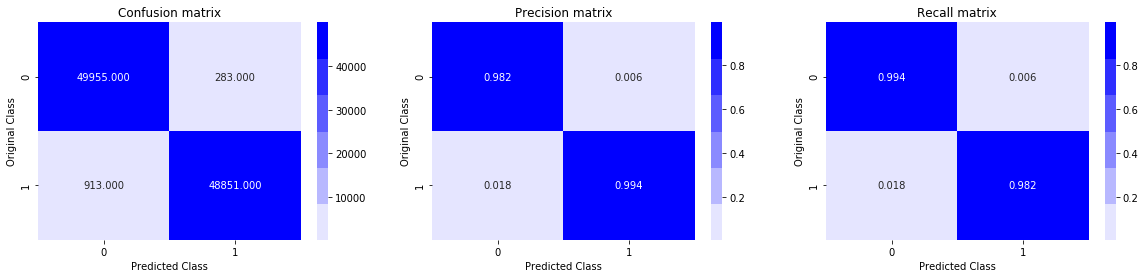

Test confusion_matrix


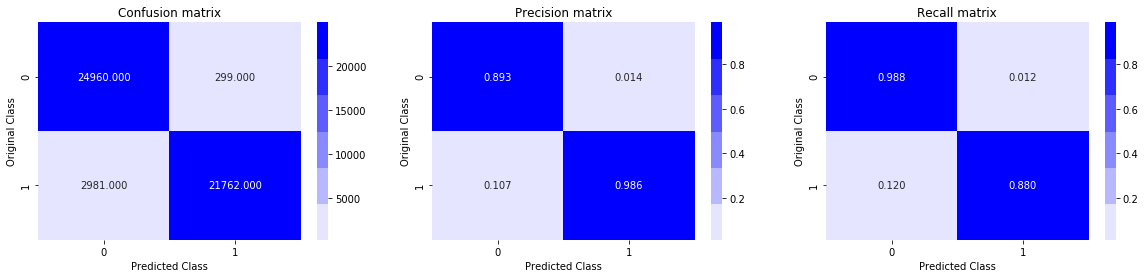

In [15]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

###### ROC Curve

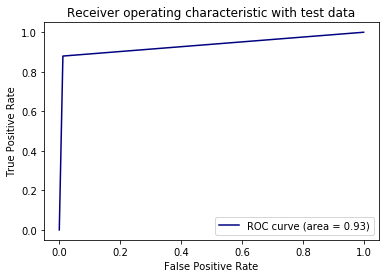

In [16]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

###### Feature Importance

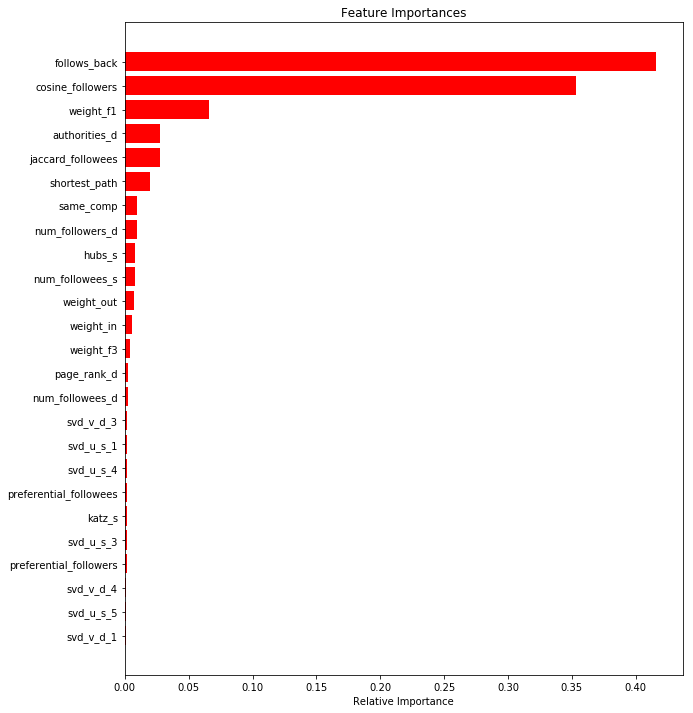

In [17]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

     Observation:
       1. In XBGoost most of features are less useful for predicting link between two pair of nodes.
       2. In RandomForestClassifier ,of all half the features are useful in predicting link between two pair of nodes.
       3. When we observe both the model "followback" feature is very useful in predicted the labels.
       

                                                                 Summary
                    +--------------------+--------------------------+-----------------------+-----------------------+
                    |        S.No        |          Model           |     Train F1 Score    |      Test F1 Score    |
                    +--------------------+--------------------------+-----------------------+-----------------------+
                    |          1         |  RandomForestClassifier  |        0.9652         |        0.9255         |
                    +--------------------+--------------------------+-----------------------+-----------------------+
                    |          2         |    XGBoostClassifier     |        0.9879         |        0.9299         |
                    +--------------------+--------------------------+-----------------------+-----------------------+
                    

     Conclusion : Feature Engineering is the heart of this problem.

<h3 style='font-family:Georgia;text-size:110%;'>Procedure followed to solve this case Study</h3>
<ol style='font-family:Georgia;font-size:110%;'>
    <li>Understanding the Business Problem(Statement)</li>
    <li>Data Overview</li>
    <li>Ml Problem Formulation</li>
    <li>Constructing Objectives and Constraints according to the Business Problem</li>
    <li>Key Performance Metrics to choose for the problem</li>
    <li>Exploratory Data Analysis
        <ol>
            <li>Check number of followers for each person and plotting it for visualization</li>
            <li>Check number of followees for each person and plotting it for visualization </li>
            <li>Check total of followers and folllowees</li>
        </ol>
    </li>
    <li>Posing the problem as Classification
        <ol>
         <li>Generating some random nodes pairs which links are not present in the graph</li>
         <li>Preparing data for both Train and Test</li>
         <li>Sampling some data from entire data for modelling.</li>
        </ol>
    </li>
    <li>Feature Engineering for both (Source,Destination) Pair
        <ol>
            <li>Similarity Measures
                <ol>
                    <li>Jaccard Index</li>
                    <li>Cosine Distance</li>
                    <li>Preferential Attachment</li>
                </ol>
            </li>
            <li>Ranking Measures
                <ol>
                    <li>PageRank</li>
                </ol>
            </li>
            <li>Other Graph Features
                <ol>
                   <li>Shortest Path</li>
                   <li>Checking for same community</li>
                   <li>Adamic/Adar Index</li>
                   <li>Is Person following back</li>
                   <li>Katz Centrality</li>
                   <li>Hits Score</li>
                </ol>
            </li>
            <li>Weight Features</li>
            <li>SVD Features</li>
        </ol>
    </li>
    <li>After calculating all the features and storing into separate file for both Train and Test</li>
    <li>Training Classical ML Models
        <ol>
          <li>RandomForestClassifier</li>
          <li>XGBoostClassifier</li>
        </ol>
    </li>
    <li>Comparing the results.</li>
</ol>